In [56]:
import numpy as np
import scipy.io
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow import keras
from tensorflow.keras import layers
import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

np.random.seed(123)
tf.random.set_seed(123)

# Datasets

In [3]:
dataset = "mnist"

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

def reshape_data(data):
    if data.shape[1] != 28:
        return data.reshape((-1, 28, 28)).reshape((-1, 28 * 28), order='F')
    else:
        return data.reshape((-1, 28 * 28))


if dataset == "mnist":
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    image_size = x_train.shape[1]

    x_train = np.reshape(x_train, [-1, image_size ** 2])
    x_test = np.reshape(x_test, [-1, image_size ** 2])

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

elif dataset == "fashionmnist":
    (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

    image_size = x_train.shape[1]

    x_train = np.reshape(x_train, [-1, image_size ** 2])
    x_test = np.reshape(x_test, [-1, image_size ** 2])

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

elif dataset == "omniglot":
    path = 'chardata.mat'
    omni_raw = scipy.io.loadmat(path)

    x_train = reshape_data(omni_raw['data'].T.astype("float32"))
    x_test = reshape_data(omni_raw['testdata'].T.astype("float32"))

    image_size = int(np.sqrt(x_train.shape[1]))

Found GPU at: /device:GPU:0


# Models

## Utils

In [4]:
class BasicBlock(tf.keras.Model):
  def __init__(self, det_dim, latent_dim, **kwargs):
    super(BasicBlock, self).__init__(**kwargs)
    self.det_dim = det_dim
    self.latent_dim = latent_dim
    self.deterministic = tf.keras.Sequential([layers.Dense(det_dim, activation="tanh"), 
                                              layers.Dense(det_dim, activation="tanh")])
    
    self.layer_mean = layers.Dense(latent_dim, name="h_mean", activation=None)
    self.layer_std = layers.Dense(latent_dim, name="h_std", activation="exponential")
  
  def call(self, input):
    output_det = self.deterministic(input)
    mu = self.layer_mean(output_det)
    std = self.layer_std(output_det)

    Q_h_inpt = tfd.Normal(mu, std + 1e-6)

    return mu, std, Q_h_inpt

class Sampling_Bernoulli(layers.Layer):
  """Uses (mean) to sample x, the vector encoding an output image."""

  def call(self, z_mean):
      output = tfp.distributions.Bernoulli(probs=z_mean, dtype=tf.float32).sample()
      return output


class Sampling_Normal(layers.Layer):
  """Uses (mu_h, sigma_h) to sample h, the vector encoding a digit."""

  def call(self, inputs, num_samples=1):
      mu_h, sigma_h = inputs
      batch = mu_h.shape[-2] #(num_samples, batch_size, dim)
      dim = sigma_h.shape[-1]
      epsilon = tfd.Normal(np.zeros((batch,dim)), np.ones((batch,dim))).sample(num_samples)
      epsilon = tf.cast(epsilon, tf.float32)
      if(len(mu_h.shape) == 2):
        mu_h = tf.reshape(tf.tile(mu_h, [num_samples, 1]), [num_samples, batch, dim])
        sigma_h = tf.reshape(tf.tile(sigma_h, [num_samples, 1]), [num_samples, batch, dim])
      return mu_h + sigma_h * epsilon, epsilon

log2pi = tf.math.log(2 * np.pi)
def log_mean_exp(x, axis):
  m = tf.reduce_max(x, axis=axis, keepdims=True)
  return m + tf.math.log(tf.reduce_mean(tf.math.exp(x - m), axis=axis, keepdims=True))

In [5]:
def get_bias():
    Ntrain = x_train.shape[0]

    mnist_train = x_train.reshape(Ntrain, -1)
    train_mean = np.mean(x_train, axis=0)

    bias = -np.log(1. / np.clip(train_mean, 0.001, 0.999) - 1.)

    return tf.constant_initializer(bias)

## One latent layer

In [6]:
class IWAE1(tf.keras.Model):
  def __init__(self, input_dim, det_dim, latent_dim, **kwargs):
    super(IWAE1, self).__init__(**kwargs)
    self.input_dim = input_dim
    self.det_dim = det_dim
    self.latent_dim = latent_dim

    self.encoder_h1 = BasicBlock(det_dim, latent_dim)

    self.decoder_x = tf.keras.Sequential([layers.Dense(det_dim, activation="tanh"), 
                                        layers.Dense(det_dim, activation="tanh"),
                                        layers.Dense(input_dim, activation=None,
                                                     bias_initializer=get_bias())]) # dont need sigmoid if using logits
    
    
    
  def encoder(self, x, num_samples):
    mu_h1, sigma_h1, q_h1_x = self.encoder_h1(x)
    #h_1, eps = Sampling_Normal()([mu_h1, sigma_h1], num_samples)
    h_1 = q_h1_x.sample(num_samples)
    # shape: (num_samples, batch_size, latent_dim)
    return mu_h1, sigma_h1, h_1, q_h1_x
  
  def decoder(self, h1):
    logits = self.decoder_x(h1)
    prob_x = tfd.Bernoulli(logits=logits)
    return logits, prob_x
  
  def call(self, x, num_samples, objective = "vae"):
    """
    mu_h1, sigma_h1, h_1, eps = self.encoder(x, num_samples)
    logits, prob_x = self.decoder(h_1)

    lQ_h1_x = tf.reduce_sum(-0.5*(eps)**2 - tf.math.log(sigma_h1) -0.5*log2pi, axis=-1)  #(num_samples, batch_size,)
    lP_h1 = tf.reduce_sum(-0.5*h_1**2 -0.5*log2pi, axis=-1)
    lP_x_h1 = tf.reduce_sum(prob_x.log_prob(x), axis=-1)
    """

    mu_h1, sigma_h1, h_1, q_h1_x = self.encoder(x, num_samples)
    logits, prob_x = self.decoder(h_1)

    lQ_h1_x = tf.reduce_sum(q_h1_x.log_prob(h_1), axis=-1)  #(num_samples, batch_size,)
    p_h1 = tfd.Normal(0, 1)
    lP_h1 = tf.reduce_sum(p_h1.log_prob(h_1), axis=-1)
    lP_x_h1 = tf.reduce_sum(prob_x.log_prob(x), axis=-1)

    log_w = lP_h1 + lP_x_h1 - lQ_h1_x # Shape (num_samples, batch_size,)

    if objective == "vae":
      # First the mean over the samples
      # Second the mean over the elbos
      mean_loss = tf.reduce_mean(tf.reduce_mean(log_w, axis=0), axis=-1)
      
    elif objective == "iwae":
      w = tf.exp(log_w - tf.reduce_max(log_w, axis=0, keepdims=True))
      w_norm = w / tf.reduce_sum(w, axis=0, keepdims=True)
      w_norm = tf.stop_gradient(w_norm)
      mean_loss = tf.reduce_mean(tf.reduce_sum(w_norm*log_w, axis=0))

    return -mean_loss
  
  @tf.function
  def train_step(self, x, num_samples, optimizer, objective="vae"):
    with tf.GradientTape() as tape:
      loss = self.call(x, num_samples, objective)
      
    grads = tape.gradient(loss, self.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.trainable_weights))
    return loss

  @tf.function
  def val_step(self, x, num_samples, objective="vae"):
    return self.call(x, num_samples, objective)
  
  def estimate_log_like_batch(self, x, num_samples=5000):
    mu_h1, sigma_h1, h_1, q_h1_x = self.encoder(x, num_samples)
    logits, prob_x = self.decoder(h_1)

    lQ_h1_x = tf.reduce_sum(q_h1_x.log_prob(h_1), axis=-1)  #(num_samples, batch_size,)
    p_h1 = tfd.Normal(0, 1)
    lP_h1 = tf.reduce_sum(p_h1.log_prob(h_1), axis=-1)
    lP_x_h1 = tf.reduce_sum(prob_x.log_prob(x), axis=-1)

    log_w = lP_h1 + lP_x_h1 - lQ_h1_x # Shape (num_samples, batch_size,)


    return tf.reduce_mean(tfp.math.reduce_logmeanexp(log_w, axis=0), axis=-1)

  @staticmethod
  def write_to_tensorboard(res, step):
    tf.summary.scalar('ELBO', -res, step=step)


## Two latent layers

In [7]:
class IWAE2(tf.keras.Model):
  def __init__(self, input_dim, det_dim1,det_dim2, latent_dim1, latent_dim2, **kwargs):
    super(IWAE2, self).__init__(**kwargs)
    self.input_dim = input_dim
    self.det_dim1 = det_dim1
    self.det_dim2 = det_dim2

    # Encoder
    self.encoder_h1 = BasicBlock(det_dim1, latent_dim1)
    self.encoder_h2 = BasicBlock(det_dim2, latent_dim2)

    self.decoder_h1 = BasicBlock(det_dim2, latent_dim1)
    self.decoder_x = tf.keras.Sequential([layers.Dense(det_dim1, activation="tanh"), 
                                        layers.Dense(det_dim1, activation="tanh"),
                                        layers.Dense(input_dim, activation=None
                                                    ,bias_initializer=get_bias()      
                                                     )]) # dont need sigmoid if using logits
  def encoder(self, x, num_samples):
    mu_h1, sigma_h1, q_h1_x = self.encoder_h1(x)

    #h_1, eps1 = Sampling_Normal()([mu_h1, sigma_h1], num_samples)
    h_1 = q_h1_x.sample(num_samples)

    mu_h2, sigma_h2, q_h2_h1 = self.encoder_h2(h_1)

    #h_2, eps2 = Sampling_Normal()([mu_h2, sigma_h2], num_samples)
    h_2 = q_h2_h1.sample()
    # shape: (num_samples, batch_size, latent_dim)
    return (mu_h1, sigma_h1, h_1, q_h1_x), (mu_h2, sigma_h2, h_2, q_h2_h1)
  
  def decoder(self, h1, h2):
    mu_h1, sigma_h1, p_h1_h2 = self.decoder_h1(h2)
    logits = self.decoder_x(h1)
    prob_x = tfd.Bernoulli(logits=logits)

    return (h1, mu_h1, sigma_h1, p_h1_h2), (logits, prob_x)
  
  def call(self, x, num_samples, objective = "vae"):
    """
    (mu_h1, sigma_h1, h_1, eps1), (mu_h2, sigma_h2, h_2, eps2) = self.encoder(x, num_samples)
    (h1, mu_h1, sigma_h1), (logits, prob_x) = self.decoder(h_1,h_2)

    lQ_h1_x = tf.reduce_sum(-0.5*(eps1)**2 - tf.math.log(sigma_h1) -0.5*log2pi, axis=-1)  #(num_samples, batch_size,)
    lQ_h2_h1 = tf.reduce_sum(-0.5*(eps2)**2 - tf.math.log(sigma_h2) -0.5*log2pi, axis=-1)


    lP_h2 = tf.reduce_sum(-0.5*h_2**2 -0.5*log2pi, axis=-1)
    lP_h1_h2 = tf.reduce_sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - tf.math.log(sigma_h1) -0.5*log2pi, axis=-1)
    lP_x_h1 = tf.reduce_sum(prob_x.log_prob(x), axis=-1)
    """

    (mu_h1, sigma_h1, h_1, q_h1_x), (mu_h2, sigma_h2, h_2, q_h2_h1) = self.encoder(x, num_samples)
    (h1, mu_h1, sigma_h1, p_h1_h2), (logits, prob_x) = self.decoder(h_1,h_2)
    
    lQ_h1_x = tf.reduce_sum(q_h1_x.log_prob(h_1), axis=-1)  #(num_samples, batch_size,)
    lQ_h2_h1 = tf.reduce_sum(q_h2_h1.log_prob(h_2), axis=-1) 
   
    p_h2 = tfd.Normal(0, 1)
    lP_h2 = tf.reduce_sum(p_h2.log_prob(h_2), axis=-1)
    lP_h1_h2 = tf.reduce_sum(p_h1_h2.log_prob(h_1), axis=-1)
    lP_x_h1 = tf.reduce_sum(prob_x.log_prob(x), axis=-1)

    log_w = lP_h2 + lP_h1_h2 + lP_x_h1 - lQ_h1_x - lQ_h2_h1 # Shape (num_samples, batch_size,)

    if objective == "vae":
      # First the mean over the samples
      # Second the mean over the elbos
      mean_loss = tf.reduce_mean(tf.reduce_mean(log_w, axis=0), axis=-1)
      
    elif objective == "iwae":
      w = tf.exp(log_w - tf.reduce_max(log_w, axis=0, keepdims=True))
      w_norm = w / tf.reduce_sum(w, axis=0, keepdims=True)
      w_norm = tf.stop_gradient(w_norm)
      mean_loss = tf.reduce_mean(tf.reduce_sum(w_norm*log_w, axis=0))

    return -mean_loss
  
  @tf.function
  def train_step(self, x, num_samples, optimizer, objective="vae"):
    with tf.GradientTape() as tape:
      loss = self.call(x, num_samples, objective)
      
    grads = tape.gradient(loss, self.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.trainable_weights))
    return loss

  @tf.function
  def val_step(self, x, num_samples, objective="vae"):
    return self.call(x, num_samples, objective)
  
  def estimate_log_like_batch(self, x, num_samples=5000):
    """
    (mu_h1, sigma_h1, h_1, eps1), (mu_h2, sigma_h2, h_2, eps2) = self.encoder(x, num_samples)
    (h1, mu_h1, sigma_h1), (logits, prob_x) = self.decoder(h_1,h_2)
    
    lQ_h1_x = tf.reduce_sum(-0.5*(eps1)**2 - tf.math.log(sigma_h1) -0.5*log2pi, axis=-1)  #(num_samples, batch_size,)
    lQ_h2_h1 = tf.reduce_sum(-0.5*(eps2)**2 - tf.math.log(sigma_h2) -0.5*log2pi, axis=-1)


    lP_h2 = tf.reduce_sum(-0.5*h_2**2 -0.5*log2pi, axis=-1)
    lP_h1_h2 = tf.reduce_sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - tf.math.log(sigma_h1) -0.5*log2pi, axis=-1)
    lP_x_h1 = tf.reduce_sum(prob_x.log_prob(x), axis=-1)

    log_w = lP_h2 + lP_h1_h2 + lP_x_h1 - lQ_h1_x - lQ_h2_h1 # Shape (num_samples, batch_size,)
    """

    (mu_h1, sigma_h1, h_1, q_h1_x), (mu_h2, sigma_h2, h_2, q_h2_h1) = self.encoder(x, num_samples)
    (h1, mu_h1, sigma_h1, p_h1_h2), (logits, prob_x) = self.decoder(h_1,h_2)
    
    lQ_h1_x = tf.reduce_sum(q_h1_x.log_prob(h_1), axis=-1)  #(num_samples, batch_size,)
    lQ_h2_h1 = tf.reduce_sum(q_h2_h1.log_prob(h_2), axis=-1) #
    p_h2 = tfd.Normal(0, 1)
    lP_h2 = tf.reduce_sum(p_h2.log_prob(h_2), axis=-1)
    lP_h1_h2 = tf.reduce_sum(p_h1_h2.log_prob(h_1), axis=-1)
    lP_x_h1 = tf.reduce_sum(prob_x.log_prob(x), axis=-1)

    log_w = lP_h2 + lP_h1_h2 + lP_x_h1 - lQ_h1_x - lQ_h2_h1 # Shape (num_samples, batch_size,)
    
    return tf.reduce_mean(tfp.math.reduce_logmeanexp(log_w, axis=0), axis=-1)

  @staticmethod
  def write_to_tensorboard(res, step):
    tf.summary.scalar('ELBO', -res, step=step)

# Training

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def scheduler():
  result = {}
  epoch = 0
  for i in range(8):
    result[epoch] = 0.001 * 10**(-i/7)
    epoch += 3 ** i

  return result

In [35]:
num_samples = 50
batch_size = 20
epochs = 1000 # 3280
steps_pr_epoch = x_train.shape[0] // batch_size
total_steps = steps_pr_epoch * epochs
stochastic_layer_count = 1
#objective = "iwae"
objective = "vae"
init_epoch = 0

if stochastic_layer_count == 1:
  n_latent = [50]
  n_hidden = [200]
  model = IWAE1(x_train.shape[1], n_hidden[0], n_latent[0])
else:
  n_latent = [100,50]
  n_hidden = [200,100]
  model = IWAE2(x_train.shape[1], n_hidden[0],n_hidden[1], n_latent[0], n_latent[1])

In [ ]:
# Tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = f"/tmp/iwae/{objective}_{num_samples}_t{stochastic_layer_count}/"+ current_time + "/train"
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = f"/tmp/iwae/{objective}_{num_samples}_t{stochastic_layer_count}/" + current_time + "/test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
log = f"/tmp/iwae/{objective}_{num_samples}_t{stochastic_layer_count}/"+ current_time

lr = 0.001
schedule_lr = scheduler()
optimizer = keras.optimizers.Adam(learning_rate=schedule_lr[0], beta_1=0.9, beta_2=0.999, epsilon=1e-4)

if init_epoch != 0:
  for epoch in range(init_epoch, -1, -1):
    if epoch in schedule_lr:
      optimizer.learning_rate.assign(schedule_lr[epoch])
      print("New lr:", schedule_lr[epoch])
      break

X_test = np.random.binomial(1, x_test, size=x_test.shape)

for epoch in range(init_epoch, epochs):
  X_train = np.random.binomial(1, x_train, size=x_train.shape)

  train_dataset = (tf.data.Dataset.from_tensor_slices(X_train)
      .shuffle(X_train.shape[0]).batch(batch_size))
  
  if epoch in schedule_lr:
    optimizer.learning_rate.assign(schedule_lr[epoch])
    print("New lr:", schedule_lr[epoch])

  for _step, x_batch in enumerate(train_dataset):
    # print(x_batch.shape) -> (batch_size, image_dim)
    
    step = _step + steps_pr_epoch * epoch

    res = model.train_step(x_batch, num_samples, objective=objective, optimizer=optimizer)
    
    if step % 200 == 0:
      with train_summary_writer.as_default():
          model.write_to_tensorboard(res, step)

      test_res = model.val_step(X_test, num_samples, objective=objective)

      with test_summary_writer.as_default():
          model.write_to_tensorboard(test_res, step)

      print("epoch {0}/{1}, step {2}/{3}, train ELBO: {4:.2f}, test ELBO: {5:.2f}"
            .format(epoch+1, epochs, step, total_steps, res.numpy(), test_res))
      
  if epoch % 100 == 0:
    model.save_weights(f"/content/drive/MyDrive/iwae/{objective}_{num_samples}_t{stochastic_layer_count}_final/temp_w/temp_weights_{epoch}")
      
model.save_weights(f"/content/drive/MyDrive/iwae/{objective}_{num_samples}_t{stochastic_layer_count}_final/final_w/final_weights_{epoch}")

New lr: 0.001
epoch 1/1000, step 0/3000000, train ELBO: 230.42, test ELBO: 219.60
epoch 1/1000, step 200/3000000, train ELBO: 174.42, test ELBO: 170.60
epoch 1/1000, step 400/3000000, train ELBO: 146.89, test ELBO: 157.33
epoch 1/1000, step 600/3000000, train ELBO: 141.76, test ELBO: 147.89
epoch 1/1000, step 800/3000000, train ELBO: 142.78, test ELBO: 141.76
epoch 1/1000, step 1000/3000000, train ELBO: 143.53, test ELBO: 138.12
epoch 1/1000, step 1200/3000000, train ELBO: 135.76, test ELBO: 135.51
epoch 1/1000, step 1400/3000000, train ELBO: 132.53, test ELBO: 132.97
epoch 1/1000, step 1600/3000000, train ELBO: 120.97, test ELBO: 129.92
epoch 1/1000, step 1800/3000000, train ELBO: 135.28, test ELBO: 128.62
epoch 1/1000, step 2000/3000000, train ELBO: 126.53, test ELBO: 126.72
epoch 1/1000, step 2200/3000000, train ELBO: 133.02, test ELBO: 125.14
epoch 1/1000, step 2400/3000000, train ELBO: 132.59, test ELBO: 124.20
epoch 1/1000, step 2600/3000000, train ELBO: 131.00, test ELBO: 122.79

In [16]:
model.save_weights(f"iwae/{objective}_{num_samples}_t{stochastic_layer_count}_final/final_w/final_weights_{epoch}")

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir log

## Load model

In [17]:
X_train = np.random.binomial(1, x_train, size=x_train.shape)
X_test = np.random.binomial(1, x_test, size=x_test.shape)

In [36]:
saved_epoch = 999
init_epoch = saved_epoch + 1

In [37]:
checkpoint_path=f"iwae/{objective}_{num_samples}_t{stochastic_layer_count}_final/"

if saved_epoch == 999:
  checkpoint_path += f"final_w/final_weights_{saved_epoch}"
else:
  checkpoint_path += f"temp_w/temp_weights_{saved_epoch}"

In [38]:
model.built = True
model.load_weights(checkpoint_path)

# Experiments

0) log likelihood 2 layer reduce mean 5x5 check?

1) Try both x_train and x_test.

2) Try both z_mean and z.

3) check the range of z. (scatter labels?, scale?)

4) If you understand scatter, plot seperately for each label. Compare vae and iwae.

5) flat reconstruction visualize output.


## Negative log-likelihood

In [15]:
def estimate_log_like_dataset_batch(model, x, batch_size=20, num_samples=5000):
  train_dataset = (tf.data.Dataset.from_tensor_slices(x)
      .shuffle(x.shape[0]).batch(batch_size))
  res = 0.0
  for _step, x_batch in enumerate(train_dataset):
    # print(x_batch.shape) -> (batch_size, image_dim)
  
    res += model.estimate_log_like_batch(x_batch, num_samples)
  
  return res

def estimate_log_like_dataset(model, x, num_samples=5000):
  train_dataset = (tf.data.Dataset.from_tensor_slices(x)
      .shuffle(x.shape[0]).batch(batch_size))
  res = []
  for _step, x in enumerate(x):
    # print(x_batch.shape) -> (batch_size, image_dim)
    res.append(model.estimate_log_like_batch(x.reshape(1,-1), num_samples))
  
  return tf.reduce_mean(res).numpy()

In [40]:
print("log_like est:", estimate_log_like_dataset(model, X_test, num_samples))
#print("log_like est:", estimate_log_like_dataset(model, X_train, num_samples))

log_like est: -87.41092


## Active units

In [19]:
def find_active_units(model, data, num_samples, stochastic_layer_count):
  if stochastic_layer_count == 1:
    z_mean_1, _, h, _ = model.encoder(data, num_samples)
    # (size_data, dim_latent)

    #variances_1 = np.var(h, axis=0)
    variances_1 = np.var(z_mean_1, axis=0)
    active_neurons_1 = np.where(variances_1 > 1e-2, 1, 0)
    active_neuron_count_1 = np.count_nonzero(active_neurons_1)

    print(f"Active units: {active_neuron_count_1}")

  elif stochastic_layer_count == 2:
    (z_mean_1, _, h_1, _), (z_mean_2, _, h_2, _) = model.encoder(data, num_samples)
    # (size_data, dim_latent) || (num_samples, size_data, dim_latent)

    #variances_1 = np.var(h_1, axis=0)
    variances_1 = np.var(z_mean_1, axis=0)
    active_neurons_1 = np.where(variances_1 > 1e-2, 1, 0)
    active_neuron_count_1 = np.count_nonzero(active_neurons_1)

    #variances_2 = np.var(np.mean(h_2, axis=0), axis=0)
    variances_2 = np.var(np.mean(z_mean_2, axis=0), axis=0)
    active_neurons_2 = np.where(variances_2 > 1e-2, 1, 0)
    active_neuron_count_2 = np.count_nonzero(active_neurons_2)

    print(f"Active units: {active_neuron_count_1} + {active_neuron_count_2}")

In [20]:
find_active_units(model, X_test, num_samples, stochastic_layer_count)
#find_active_units(model, X_train, num_samples, stochastic_layer_count)

Active units: 23


In [41]:
def plot_label_clusters(model, data, labels, num_samples, stochastic_layer_count):
    if stochastic_layer_count == 1:
        # display a 2D plot of the digit classes in the latent space
        z_mean,_,h,_ = model.encoder(data, num_samples)
        
        #h = tf.squeeze(h)
        
        pca = PCA(n_components=2)
        pca.fit(z_mean)
        #pca.fit(h)
        z = pca.transform(z_mean)
        #z = pca.transform(h)

        plt.figure(figsize=(12, 10))
        plt.scatter(z[:, 0], z[:, 1], c=labels)
        plt.colorbar()
        plt.xlabel(r"$h_0$")
        plt.ylabel(r"$h_1$")
        plt.show()

    elif stochastic_layer_count == 2:
        # display a 2D plot of the digit classes in the latent space
        (z_mean_1,_,h_1,_), (z_mean_2,_,h_2,_) = model.encoder(data, num_samples)

        pca_1 = PCA(n_components=2)
        pca_1.fit(z_mean_1)
        #pca.fit(h_1)
        z_1 = pca_1.transform(z_mean_1)
        #z_1 = pca.transform(h_1)

        pca_2 = PCA(n_components=2)
        z_mean_2 = np.mean(z_mean_2, axis=0)
        pca_2.fit(z_mean_2)
        #pca.fit(h_2)
        z_2 = pca_2.transform(z_mean_2)
        #z_2 = pca.transform(h_2)

        fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12,10))
        a0 = ax0.scatter(z_1[:, 0], z_1[:, 1], c=labels)
        ax1.scatter(z_2[:, 0], z_2[:, 1], c=labels)

        fig.colorbar(a0, ax = [ax0, ax1])
        ax0.set(xlabel=r"$h_0^1$", ylabel=r"$h_1^1$")
        ax1.set(xlabel=r"$h_0^2$", ylabel=r"$h_1^2$")

        plt.show()

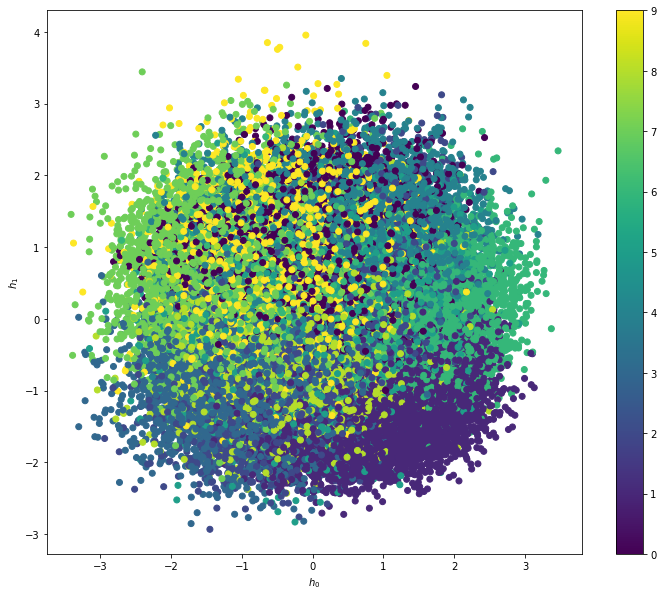

In [42]:
#plot_label_clusters(model, X_test, y_test, num_samples, stochastic_layer_count)
plot_label_clusters(model, X_train, y_train, num_samples, stochastic_layer_count)

PCA(n_components=2)

In [27]:
def plot_latent_space(model, data, num_samples, n=15, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 5.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    z_mean,_,h,_ = model.encoder(data, num_samples)

    print(tf.shape(h))
    
    h = tf.reduce_mean(h, axis=0)

    pca = PCA(n_components=2)
    pca.fit(h)
    #pca.fit(z_mean)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_mean = pca.inverse_transform(np.array([[xi, yi]]))
            z_sample = np.array(z_mean)
            _, reconstruction_dist = model.decoder(z_sample)

            x_decoded = reconstruction_dist.sample()

            digit =  tf.reshape(x_decoded[0],  (digit_size, digit_size))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

tf.Tensor([    5 10000    50], shape=(3,), dtype=int32)


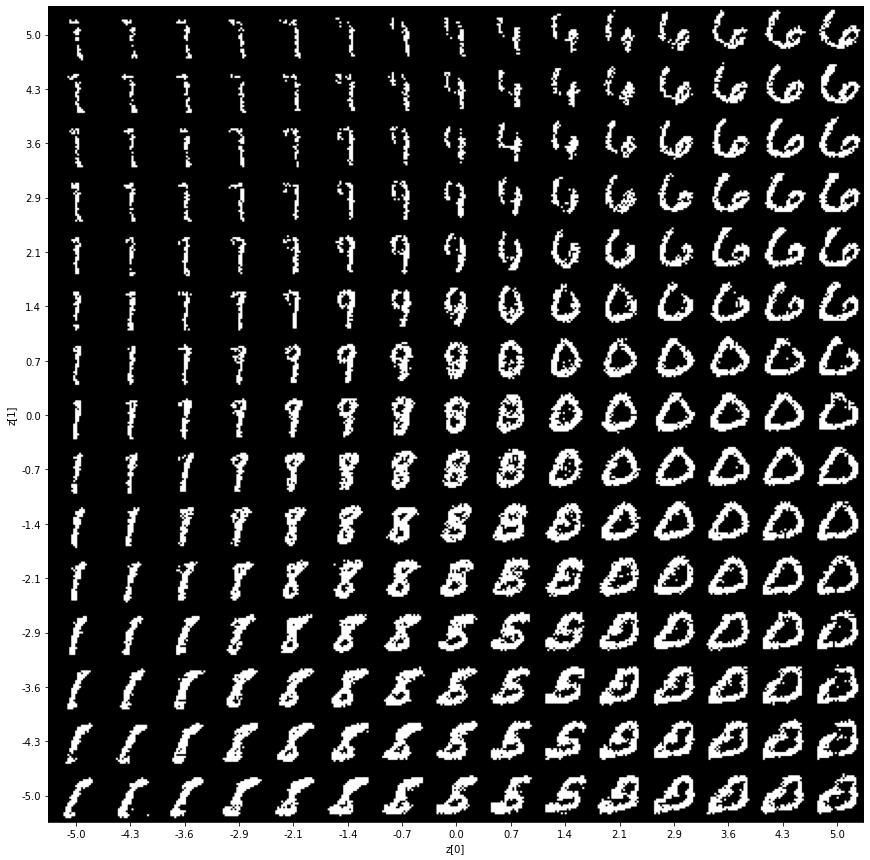

In [28]:
plot_latent_space(model, X_test, num_samples)
#plot_latent_space(model, X_train, num_samples)

## Reconstruction

In [87]:
def reconstruct(model, data, num_samples, label):

    digit_size = 28
    idx_data = np.random.permutation(len(data))
    data, labels = data[idx_data], label[idx_data]

    z_mean_all,_,h,_ = model.encoder(data, num_samples)

    h = tf.reduce_mean(h, axis=0)
    
    pca = PCA(n_components=2)
    pca.fit(h)



    for label in range(10):

        figure = np.zeros((digit_size, digit_size * 6))

        indices = np.argwhere(labels == label)
        #indices = np.nonzero(labels == label)
        digits = data[indices][:6]
        digit_labels = labels[indices][:6]

        _,_,_,q_h1_x = model.encoder(digits, num_samples)

        dist_samples = q_h1_x.sample(20000)

        dist_samples = tf.squeeze(dist_samples)

        dist_samples = tf.reshape(dist_samples, (dist_samples.shape[0] * dist_samples.shape[1], 50))

        z = pca.transform(dist_samples)

        for no, digit in enumerate(digits):
            _,_,h,q_h1_x = model.encoder(digit, num_samples)

            _, reconstruction_dist = model.decoder(h)
            reconstruction = reconstruction_dist.sample()

            reconstruction = tf.reshape(reconstruction[0], (digit_size, digit_size))

            figure[
                :,
                no * digit_size : (no + 1) * digit_size,
            ] = reconstruction

        plt.imshow(figure, cmap="Greys_r")

        uniform_data = np.random.rand(10, 12)
        plt.figure(figsize=(6, 5))
        plt.scatter(z[:, 0], z[:, 1], c=np.repeat(label, 120000))
        plt.colorbar()
        plt.xlabel(r"$h_0$")
        plt.ylabel(r"$h_1$")

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)

        plt.show()




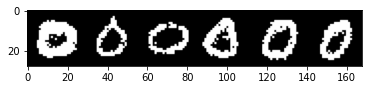

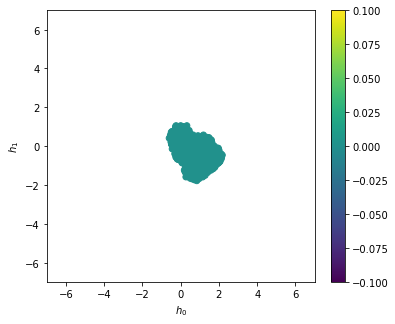

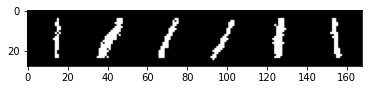

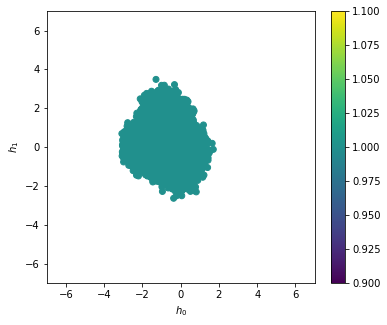

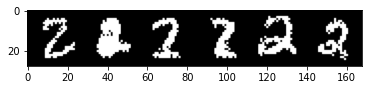

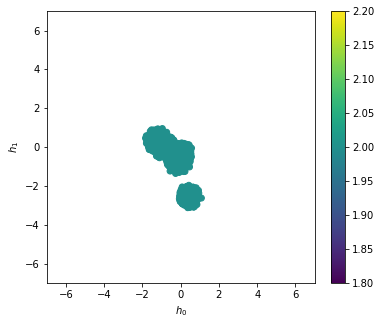

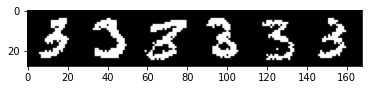

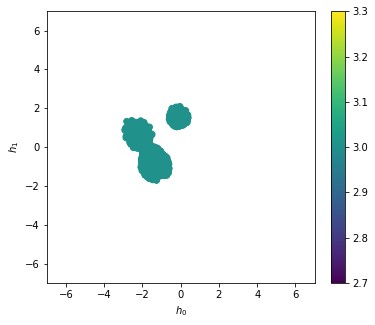

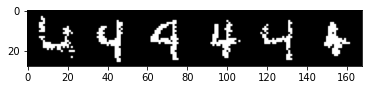

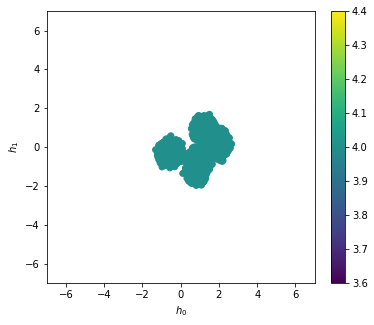

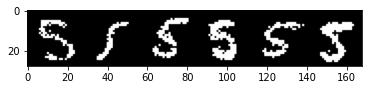

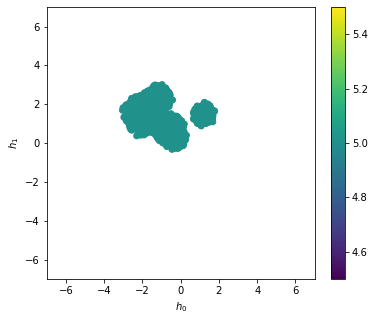

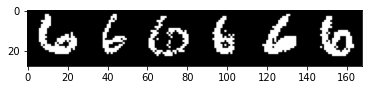

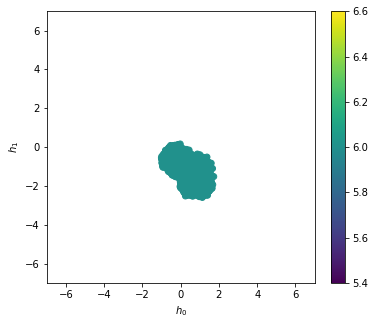

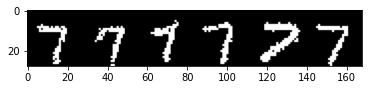

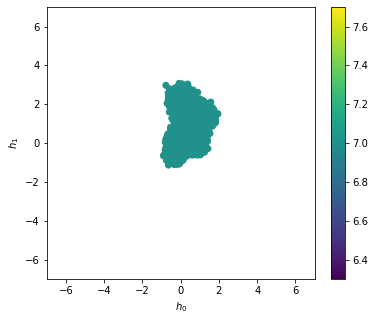

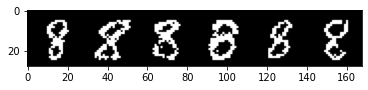

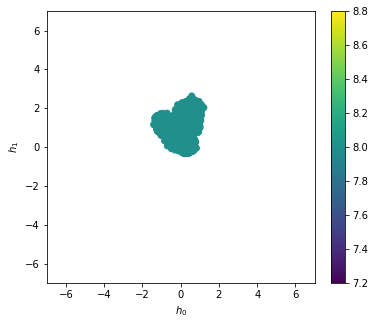

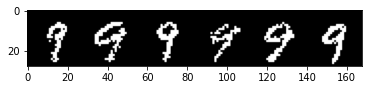

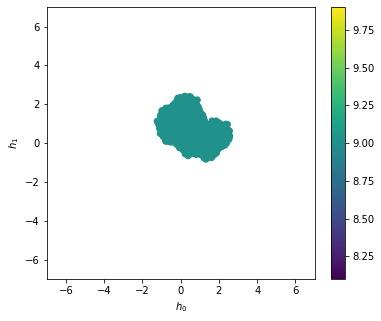

In [88]:
reconstruct(model, X_test, num_samples, y_test)
#reconstruct(model, X_train, num_samples, y_train)